# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1] Reading data

# [1.1]  Loading data

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sql
import seaborn as sns
import random
import gensim
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

C:\Users\chauh\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
con = sql.connect('D:/Work/database.sqlite')

In [3]:
filtered_data = pd.read_sql_query("""select * from Reviews where Score != 3""", con)
filtered_data.shape

(525814, 10)

In [4]:
def partition(x):
    if x < 3:
        return 'negative'
    else:
        return 'positive'

In [5]:
actual_score = filtered_data['Score']
posneg = actual_score.map(partition)
filtered_data['Score'] = posneg

sorted_data = filtered_data.sort_values('ProductId', axis=0, ascending= True, inplace= False, kind= 'quicksort', na_position='last')
final = sorted_data.drop_duplicates(subset={'UserId', 'ProfileName', 'Time', 'Text'}, keep='first', inplace=False)

final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

# [2] Pre processing

# [2.1] Processing review text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [6]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

i=0
for sent in final['Text'].values:
    if len(re.findall('<.*?',sent)):
        print(i)
        print(sent)
        break
    i += 1    

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [7]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)

{"aren't", 'what', 'was', 'wasn', 'these', 'them', 'other', 'needn', 't', "you've", "mightn't", "should've", 'their', "shan't", 'no', "hadn't", "you're", 'be', 'further', 'haven', 'weren', 'ain', 'before', "that'll", 'they', 'those', 'just', 'had', 'wouldn', 'below', "mustn't", 'o', 'ourselves', 'myself', 'into', 'theirs', 'own', 'why', 'should', 'didn', 'any', 'between', 'through', 'same', 'been', 'here', 'don', 'this', 'themselves', "doesn't", "hasn't", 'who', 'there', 'whom', 'which', 'after', "it's", 're', 've', 'in', "haven't", 'where', 'not', 'ours', 'do', 'under', 'then', 'how', 'for', 'or', 'll', 'during', 'mustn', 'his', 'shan', 'will', 'by', 'once', 'when', 'have', 'against', 'me', 'our', 'very', 'such', "she's", 'yourself', 'over', 'has', 'but', 'now', 'himself', 'and', 'hasn', 'doing', 'him', 'won', 'yourselves', "you'd", 'am', 'only', 'does', 'out', 'if', 'with', 'd', 'i', 'couldn', 'aren', 'your', 'too', 'were', "wasn't", 'are', "you'll", 'more', 'both', "needn't", 'herse

In [8]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent)
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [9]:
final['CleanedText']=final_string
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
conn = sql.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [10]:
# down sampling to make the dataset balanced.
pos = final[final['Score']=='positive'].sample(n = 50000 )
neg = final[final['Score']=='negative'].sample(n = 50000)
final_ = pd.concat([pos,neg])
print(final_.shape)

(100000, 11)


In [11]:
data_sorted = final_.sort_values(by=['Time'], ascending=True)
data_sorted = data_sorted[['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Time','Summary','Text','CleanedText','Score']]

In [12]:
# data split
X_train, X_test, Y_train, Y_test = train_test_split(data_sorted['CleanedText'].values, data_sorted['Score'].values, test_size = 0.3)

# [3] Featurization

# [3.1] Bow

In [65]:
#unigram
count_vect = CountVectorizer()#max_features=5000)
X_tr = count_vect.fit_transform(X_train)
X_te = count_vect.transform(X_test)

#standardization
from sklearn.preprocessing import StandardScaler
std = StandardScaler(copy=True, with_mean=False, with_std=True)

#print(X_tr.shape)
#print(X_te.shape)

X_tra = std.fit_transform(X_tr)#.todense())
X_tes = std.transform(X_te)#.todense())

print(X_tra.shape)
print(X_tes.shape)

(70000, 32632)
(30000, 32632)


## [3.1.1] Random Forest

In [66]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, make_scorer

def custom_auc(ground_truth, predictions):
    fpr, tpr, _ = roc_curve(ground_truth, predictions[:, 1], pos_label='positive')    
    return auc(fpr, tpr)

auc_ = make_scorer(custom_auc, greater_is_better=True, needs_proba=True)

base_models = [i for i in range(1,200,50)]
depth = [i for i in range(1,151,50)]

clf = RandomForestClassifier()
param_grid = {'max_depth':depth,'n_estimators':base_models}
gsv = GridSearchCV(estimator = clf, param_grid=param_grid, scoring=auc_)
gsv.fit(X_tra, Y_train)
print("best depth = ", gsv.best_params_)
print("Best AUC score = ", gsv.best_score_)

best depth =  {'max_depth': 101, 'n_estimators': 151}
Best AUC score =  0.935179248883


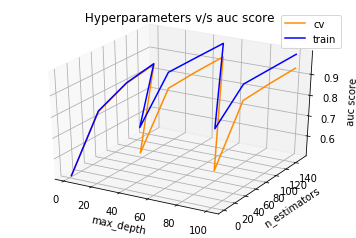

In [67]:
a = gsv.best_params_
max_depth_opt = a['max_depth']
n_estimator_opt = a['n_estimators']

x = []
y = []
z = []
import math
from mpl_toolkits.mplot3d import Axes3D 

for i in gsv.grid_scores_:
    #print(i)
    x.append(i[0]['max_depth'])
    y.append(i[0]['n_estimators'])
        
    
z_test = gsv.cv_results_['mean_test_score']    
z_train = gsv.cv_results_['mean_train_score']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')    
ax.set_xlabel('max_depth')
ax.set_ylabel('n_estimators')
ax.set_zlabel('auc score')
ax.plot(x,y,z_test, color = 'darkorange', label='cv')
ax.plot(x,y,z_train, color = 'blue', label='train')
ax.legend()
plt.title(' Hyperparameters v/s auc score')
plt.show()

## Training auc report

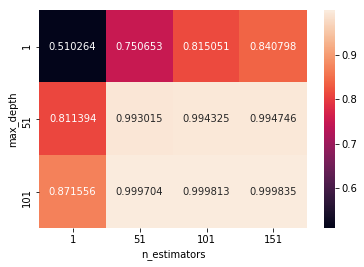

In [68]:
import seaborn as sns

dat1 = pd.DataFrame(x, columns=['max_depth'])
dat1['n_estimators'] = y
dat1['auc_score'] = z_train
da1 = dat1.pivot('max_depth','n_estimators','auc_score')
ax1 = sns.heatmap(da1, annot=True, fmt="f")

## Cross validation auc report

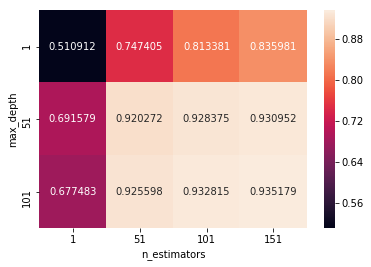

In [69]:
dat2 = pd.DataFrame(x, columns=['max_depth'])
dat2['n_estimators'] = y
dat2['auc_score'] = z_test
da2 = dat2.pivot('max_depth','n_estimators','auc_score')
ax2 = sns.heatmap(da2, annot=True, fmt="f")

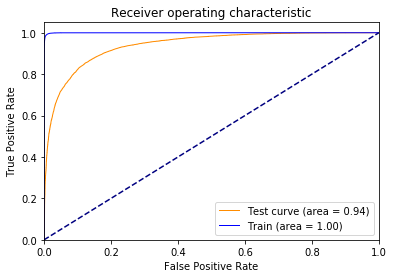

Accuracy on test set: 0.86%
Precision on test set: 0.86%
Recall on test set: 0.86%
F1 score on test set: 0.86%


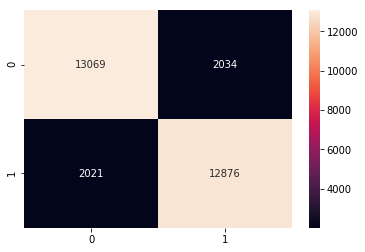

In [70]:
#training the model with best value of hyper parameter
clf = RandomForestClassifier(max_depth=max_depth_opt, n_estimators=n_estimator_opt)
clf.fit(X_tra,Y_train)
y_pred = clf.predict_proba(X_tes)
y_pred_tr = clf.predict_proba(X_tra)
y_pr = clf.predict(X_tes)

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Y_test, y_pred[:,1], pos_label='positive')
fpr_tr, tpr_tr, thresholds_tr = roc_curve(Y_train, y_pred_tr[:,1], pos_label='positive')

roc_auc_te = auc(fpr, tpr)
roc_auc_tr = auc(fpr_tr, tpr_tr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='Test curve (area = %0.2f)' % roc_auc_te)
plt.plot(fpr_tr, tpr_tr, color='blue', lw=1, label='Train (area = %0.2f)' % roc_auc_tr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

print('Accuracy on test set: %0.2f%%'%(accuracy_score(Y_test, y_pr)))
print('Precision on test set: %0.2f%%'%(precision_score(Y_test, y_pr, pos_label='positive')))
print('Recall on test set: %0.2f%%'%(recall_score(Y_test, y_pr, pos_label='positive')))
print('F1 score on test set: %0.2f%%'%(f1_score(Y_test, y_pr, pos_label='positive')))
ax = sns.heatmap(confusion_matrix(Y_test, y_pr), annot=True, fmt='d')

## Word Cloud for the most important feature names

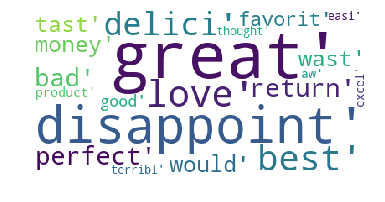

In [71]:
fn = count_vect.get_feature_names()
imp = clf.feature_importances_
indices = np.argsort(imp)[::-1][:20]

names = np.array(fn)

from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(background_color='white',
                          stopwords = set(STOPWORDS)
                      ).generate(str(names[indices]))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## [3.1.2] Gradient Boosting Decision Trees

In [72]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, make_scorer

def custom_auc(ground_truth, predictions):
    fpr, tpr, _ = roc_curve(ground_truth, predictions[:, 1], pos_label='positive')    
    return auc(fpr, tpr)

auc_ = make_scorer(custom_auc, greater_is_better=True, needs_proba=True)

base_models = [i for i in range(1,200,50)]
depth = [i for i in range(1,10,2)]
clf = XGBClassifier(booster='gbtree')
param_grid = {'max_depth':depth,'n_estimators':base_models}
gsv = GridSearchCV(estimator = clf, param_grid=param_grid, verbose=1, scoring=auc_)
gsv.fit(X_tra, Y_train)
print("best depth = ", gsv.best_params_)
print("Best AUC score = ", gsv.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 16.8min finished


best depth =  {'max_depth': 9, 'n_estimators': 151}
Best AUC score =  0.925694008638


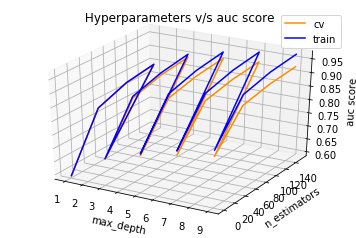

In [73]:
a = gsv.best_params_
max_depth_opt = a['max_depth']
n_estimator_opt = a['n_estimators']

x = []
y = []
z = []
import math
from mpl_toolkits.mplot3d import Axes3D 

for i in gsv.grid_scores_:
    #print(i)
    x.append(i[0]['max_depth'])
    y.append(i[0]['n_estimators'])
        
    
z_test = gsv.cv_results_['mean_test_score']    
z_train = gsv.cv_results_['mean_train_score']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')    
ax.set_xlabel('max_depth')
ax.set_ylabel('n_estimators')
ax.set_zlabel('auc score')
ax.plot(x,y,z_test, color = 'darkorange', label='cv')
ax.plot(x,y,z_train, color = 'blue', label='train')
ax.legend()
plt.title(' Hyperparameters v/s auc score')
plt.show()

## Training auc report

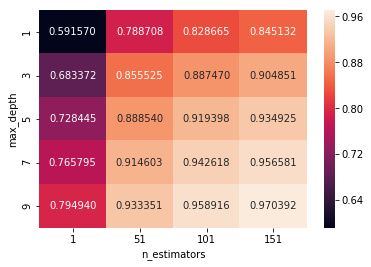

In [74]:
import seaborn as sns

dat1 = pd.DataFrame(x, columns=['max_depth'])
dat1['n_estimators'] = y
dat1['auc_score'] = z_train
da1 = dat1.pivot('max_depth','n_estimators','auc_score')
ax1 = sns.heatmap(da1, annot=True, fmt="f")

## Cross validation auc report

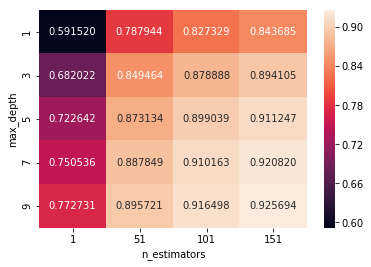

In [75]:
dat2 = pd.DataFrame(x, columns=['max_depth'])
dat2['n_estimators'] = y
dat2['auc_score'] = z_test
da2 = dat2.pivot('max_depth','n_estimators','auc_score')
ax2 = sns.heatmap(da2, annot=True, fmt="f")

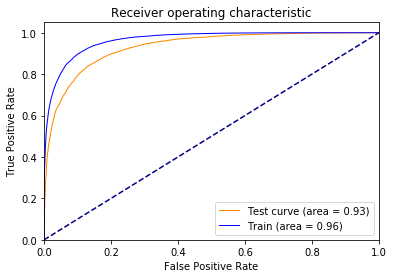

Accuracy on test set: 0.85%
Precision on test set: 0.86%
Recall on test set: 0.85%
F1 score on test set: 0.85%


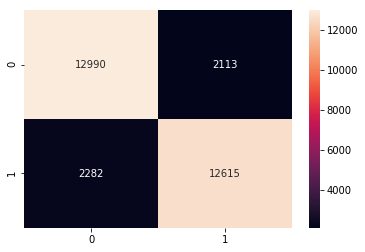

In [76]:
#training the model with best value of hyper parameter
clf = XGBClassifier(max_depth=max_depth_opt, n_estimators=n_estimator_opt, booster='gbtree')
clf.fit(X_tra,Y_train)
y_pred = clf.predict_proba(X_tes)
y_pred_tr = clf.predict_proba(X_tra)
y_pr = clf.predict(X_tes)

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Y_test, y_pred[:,1], pos_label='positive')
fpr_tr, tpr_tr, thresholds_tr = roc_curve(Y_train, y_pred_tr[:,1], pos_label='positive')

roc_auc_te = auc(fpr, tpr)
roc_auc_tr = auc(fpr_tr, tpr_tr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='Test curve (area = %0.2f)' % roc_auc_te)
plt.plot(fpr_tr, tpr_tr, color='blue', lw=1, label='Train (area = %0.2f)' % roc_auc_tr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

print('Accuracy on test set: %0.2f%%'%(accuracy_score(Y_test, y_pr)))
print('Precision on test set: %0.2f%%'%(precision_score(Y_test, y_pr, pos_label='positive')))
print('Recall on test set: %0.2f%%'%(recall_score(Y_test, y_pr, pos_label='positive')))
print('F1 score on test set: %0.2f%%'%(f1_score(Y_test, y_pr, pos_label='positive')))
ax = sns.heatmap(confusion_matrix(Y_test, y_pr), annot=True, fmt='d')

## Word Cloud for the most important features

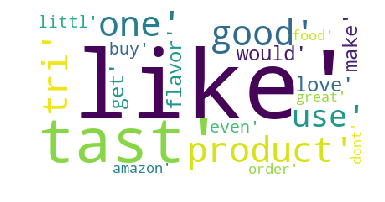

In [77]:
fn = count_vect.get_feature_names()
imp = clf.feature_importances_
indices = np.argsort(imp)[::-1][:20]

names = np.array(fn)

from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(background_color='white',
                          stopwords = set(STOPWORDS)
                      ).generate(str(names[indices]))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# [3.2] TF-IDF 

In [78]:
tfidf_vect = TfidfVectorizer()
X_tr = tfidf_vect.fit_transform(X_train)
X_te = tfidf_vect.transform(X_test)

#standardization
from sklearn.preprocessing import StandardScaler
std = StandardScaler(copy=True, with_mean=False, with_std=True)

X_tra = std.fit_transform(X_tr)
X_tes = std.fit_transform(X_te)

print(X_tra.shape)
print(X_tes.shape)

(70000, 32632)
(30000, 32632)


## [3.2.1] Random Forest

In [79]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, make_scorer

def custom_auc(ground_truth, predictions):
    fpr, tpr, _ = roc_curve(ground_truth, predictions[:, 1], pos_label='positive')    
    return auc(fpr, tpr)

auc_ = make_scorer(custom_auc, greater_is_better=True, needs_proba=True)

base_models = [i for i in range(1,200,50)]
depth = [i for i in range(1,151,50)]

clf = RandomForestClassifier()
param_grid = {'max_depth':depth,'n_estimators':base_models}
gsv = GridSearchCV(estimator = clf, param_grid=param_grid, verbose=1, scoring=auc_)
gsv.fit(X_tra, Y_train)
print("best depth = ", gsv.best_params_)
print("Best AUC score = ", gsv.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 24.2min finished


best depth =  {'max_depth': 101, 'n_estimators': 151}
Best AUC score =  0.934378088739


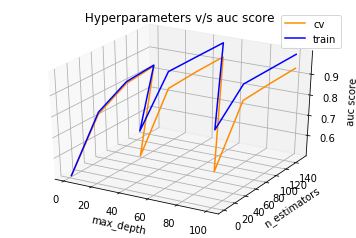

In [80]:
a = gsv.best_params_
max_depth_opt = a['max_depth']
n_estimator_opt = a['n_estimators']

x = []
y = []
z = []
import math
from mpl_toolkits.mplot3d import Axes3D 

for i in gsv.grid_scores_:
    #print(i)
    x.append(i[0]['max_depth'])
    y.append(i[0]['n_estimators'])
        
    
z_test = gsv.cv_results_['mean_test_score']    
z_train = gsv.cv_results_['mean_train_score']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')    
ax.set_xlabel('max_depth')
ax.set_ylabel('n_estimators')
ax.set_zlabel('auc score')
ax.plot(x,y,z_test, color = 'darkorange', label='cv')
ax.plot(x,y,z_train, color = 'blue', label='train')
ax.legend()
plt.title(' Hyperparameters v/s auc score')
plt.show()

## Training auc report

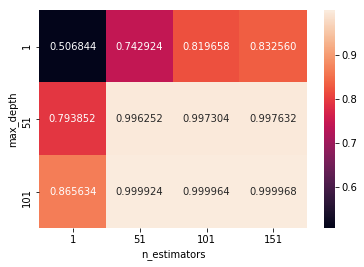

In [81]:
import seaborn as sns

dat1 = pd.DataFrame(x, columns=['max_depth'])
dat1['n_estimators'] = y
dat1['auc_score'] = z_train
da1 = dat1.pivot('max_depth','n_estimators','auc_score')
ax1 = sns.heatmap(da1, annot=True, fmt="f")

## Cross validation auc report

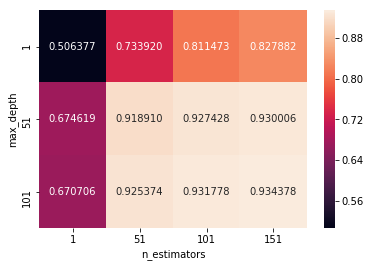

In [82]:
dat2 = pd.DataFrame(x, columns=['max_depth'])
dat2['n_estimators'] = y
dat2['auc_score'] = z_test
da2 = dat2.pivot('max_depth','n_estimators','auc_score')
ax2 = sns.heatmap(da2, annot=True, fmt="f")

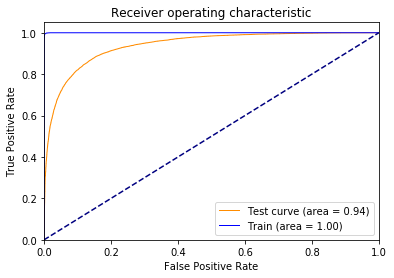

Accuracy on test set: 0.86%
Precision on test set: 0.86%
Recall on test set: 0.86%
F1 score on test set: 0.86%


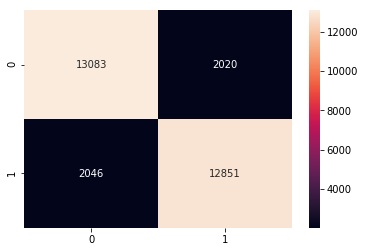

In [83]:
#training the model with best value of hyper parameter
clf = RandomForestClassifier(max_depth=max_depth_opt, n_estimators=n_estimator_opt)
clf.fit(X_tra,Y_train)
y_pred = clf.predict_proba(X_tes)
y_pred_tr = clf.predict_proba(X_tra)
y_pr = clf.predict(X_tes)

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Y_test, y_pred[:,1], pos_label='positive')
fpr_tr, tpr_tr, thresholds_tr = roc_curve(Y_train, y_pred_tr[:,1], pos_label='positive')

roc_auc_te = auc(fpr, tpr)
roc_auc_tr = auc(fpr_tr, tpr_tr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='Test curve (area = %0.2f)' % roc_auc_te)
plt.plot(fpr_tr, tpr_tr, color='blue', lw=1, label='Train (area = %0.2f)' % roc_auc_tr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

print('Accuracy on test set: %0.2f%%'%(accuracy_score(Y_test, y_pr)))
print('Precision on test set: %0.2f%%'%(precision_score(Y_test, y_pr, pos_label='positive')))
print('Recall on test set: %0.2f%%'%(recall_score(Y_test, y_pr, pos_label='positive')))
print('F1 score on test set: %0.2f%%'%(f1_score(Y_test, y_pr, pos_label='positive')))
ax = sns.heatmap(confusion_matrix(Y_test, y_pr), annot=True, fmt='d')

## Word Cloud for the most important feature names

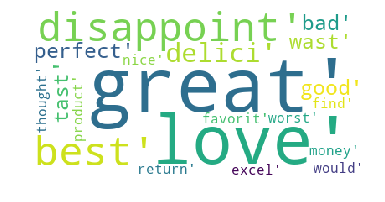

In [84]:
fn = tfidf_vect.get_feature_names()
imp = clf.feature_importances_
indices = np.argsort(imp)[::-1][:20]

names = np.array(fn)

from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(background_color='white',
                          stopwords = set(STOPWORDS)
                      ).generate(str(names[indices]))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## [3.2.2] Gradient Boosting Decision TreesGBDT

In [85]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, make_scorer

def custom_auc(ground_truth, predictions):
    fpr, tpr, _ = roc_curve(ground_truth, predictions[:, 1], pos_label='positive')    
    return auc(fpr, tpr)

auc_ = make_scorer(custom_auc, greater_is_better=True, needs_proba=True)

base_models = [i for i in range(1,200,50)]
depth = [i for i in range(1,10,2)]
clf = XGBClassifier(booster='gbtree')
param_grid = {'max_depth':depth,'n_estimators':base_models}
gsv = GridSearchCV(estimator = clf, param_grid=param_grid, verbose=1, scoring=auc_)
gsv.fit(X_tra, Y_train)
print("best depth = ", gsv.best_params_)
print("Best AUC score = ", gsv.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 29.2min finished


best depth =  {'max_depth': 9, 'n_estimators': 151}
Best AUC score =  0.926371141983


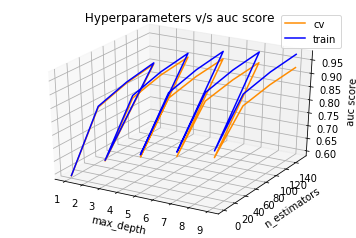

In [86]:
a = gsv.best_params_
max_depth_opt = a['max_depth']
n_estimator_opt = a['n_estimators']

x = []
y = []
z = []
import math
from mpl_toolkits.mplot3d import Axes3D 

for i in gsv.grid_scores_:
    #print(i)
    x.append(i[0]['max_depth'])
    y.append(i[0]['n_estimators'])
        
    
z_test = gsv.cv_results_['mean_test_score']    
z_train = gsv.cv_results_['mean_train_score']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')    
ax.set_xlabel('max_depth')
ax.set_ylabel('n_estimators')
ax.set_zlabel('auc score')
ax.plot(x,y,z_test, color = 'darkorange', label='cv')
ax.plot(x,y,z_train, color = 'blue', label='train')
ax.legend()
plt.title(' Hyperparameters v/s auc score')
plt.show()

## Training auc report

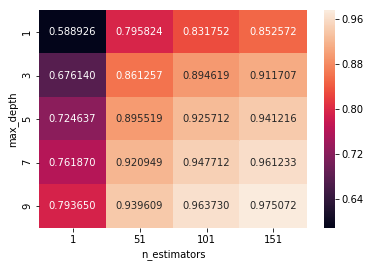

In [87]:
import seaborn as sns

dat1 = pd.DataFrame(x, columns=['max_depth'])
dat1['n_estimators'] = y
dat1['auc_score'] = z_train
da1 = dat1.pivot('max_depth','n_estimators','auc_score')
ax1 = sns.heatmap(da1, annot=True, fmt="f")

## Cross validation auc report

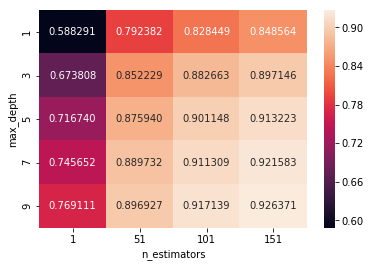

In [88]:
dat2 = pd.DataFrame(x, columns=['max_depth'])
dat2['n_estimators'] = y
dat2['auc_score'] = z_test
da2 = dat2.pivot('max_depth','n_estimators','auc_score')
ax2 = sns.heatmap(da2, annot=True, fmt="f")

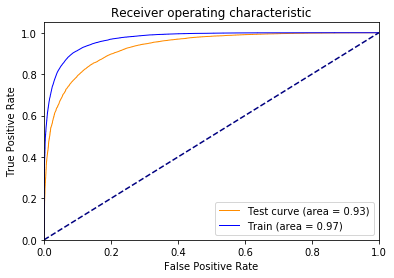

Accuracy on test set: 0.85%
Precision on test set: 0.86%
Recall on test set: 0.85%
F1 score on test set: 0.85%


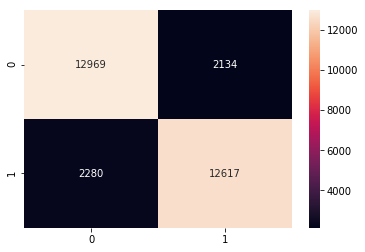

In [89]:
#training the model with best value of hyper parameter
clf = XGBClassifier(max_depth=max_depth_opt, n_estimators=n_estimator_opt, booster='gbtree')
clf.fit(X_tra,Y_train)
y_pred = clf.predict_proba(X_tes)
y_pred_tr = clf.predict_proba(X_tra)
y_pr = clf.predict(X_tes)

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Y_test, y_pred[:,1], pos_label='positive')
fpr_tr, tpr_tr, thresholds_tr = roc_curve(Y_train, y_pred_tr[:,1], pos_label='positive')

roc_auc_te = auc(fpr, tpr)
roc_auc_tr = auc(fpr_tr, tpr_tr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='Test curve (area = %0.2f)' % roc_auc_te)
plt.plot(fpr_tr, tpr_tr, color='blue', lw=1, label='Train (area = %0.2f)' % roc_auc_tr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

print('Accuracy on test set: %0.2f%%'%(accuracy_score(Y_test, y_pr)))
print('Precision on test set: %0.2f%%'%(precision_score(Y_test, y_pr, pos_label='positive')))
print('Recall on test set: %0.2f%%'%(recall_score(Y_test, y_pr, pos_label='positive')))
print('F1 score on test set: %0.2f%%'%(f1_score(Y_test, y_pr, pos_label='positive')))
ax = sns.heatmap(confusion_matrix(Y_test, y_pr), annot=True, fmt='d')

## Word Cloud for the most important feature names

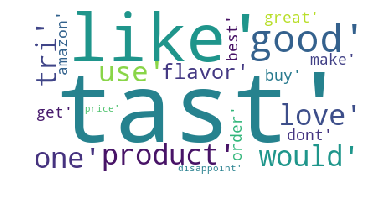

In [90]:
fn = tfidf_vect.get_feature_names()
imp = clf.feature_importances_
indices = np.argsort(imp)[::-1][:20]

names = np.array(fn)

from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(background_color='white',
                          stopwords = set(STOPWORDS)
                      ).generate(str(names[indices]))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# [3.3] W2V

In [91]:
# Training own Word2Vec model using your own train text corpus
import gensim
list_of_sent=[]

for sent in X_train:
    filtered_sentence=[]
    for word in sent.split():
        for cleaned_words in cleanpunc(word).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [92]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=100, workers=4)

In [93]:
w2v_words = list(w2v_model.wv.vocab)

In [94]:
list_of_sent_test = []
for sent in X_test:
    filtered_sentence=[]
    for word in sent.split():
        for cleaned_words in cleanpunc(word).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [95]:
w2v_words_test = list(w2v_model.wv.vocab)

# [3.3.1] Avg W2V

In [96]:
sent_vectors_TRAIN = []; 
for sent in list_of_sent: 
    sent_vec = np.zeros(100)
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_TRAIN.append(sent_vec)
    
print(len(sent_vectors_TRAIN))
print(len(sent_vectors_TRAIN[0]))    
    
    
sent_vectors_TEST = []; 
for sent in list_of_sent_test: 
    sent_vec = np.zeros(100)
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words_test:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_TEST.append(sent_vec)    

print(len(sent_vectors_TEST))
print(len(sent_vectors_TEST[0]))

70000
100
30000
100


In [97]:
#standardization
from sklearn.preprocessing import StandardScaler
std = StandardScaler(copy=True, with_mean=False, with_std=True)

X_tra = std.fit_transform(sent_vectors_TRAIN)
X_tes = std.fit_transform(sent_vectors_TEST)

print(X_tra.shape)
print(X_tes.shape)

(70000, 100)
(30000, 100)


## [3.3.1.1] Random Forest

In [98]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, make_scorer

def custom_auc(ground_truth, predictions):
    fpr, tpr, _ = roc_curve(ground_truth, predictions[:, 1], pos_label='positive')    
    return auc(fpr, tpr)

auc_ = make_scorer(custom_auc, greater_is_better=True, needs_proba=True)

base_models = [i for i in range(1,200,50)]
depth = [i for i in range(1,151,50)]

clf = RandomForestClassifier()
param_grid = {'max_depth':depth,'n_estimators':base_models}
gsv = GridSearchCV(estimator = clf, param_grid=param_grid,verbose=1, scoring=auc_)
gsv.fit(X_tra, Y_train)
print("best depth = ", gsv.best_params_)
print("Best AUC score = ", gsv.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 11.7min finished


best depth =  {'max_depth': 101, 'n_estimators': 151}
Best AUC score =  0.9118517686


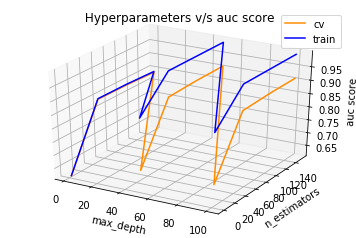

In [99]:
a = gsv.best_params_
max_depth_opt = a['max_depth']
n_estimator_opt = a['n_estimators']

x = []
y = []
z = []
import math
from mpl_toolkits.mplot3d import Axes3D 

for i in gsv.grid_scores_:
    #print(i)
    x.append(i[0]['max_depth'])
    y.append(i[0]['n_estimators'])
        
    
z_test = gsv.cv_results_['mean_test_score']    
z_train = gsv.cv_results_['mean_train_score']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')    
ax.set_xlabel('max_depth')
ax.set_ylabel('n_estimators')
ax.set_zlabel('auc score')
ax.plot(x,y,z_test, color = 'darkorange', label='cv')
ax.plot(x,y,z_train, color = 'blue', label='train')
ax.legend()
plt.title(' Hyperparameters v/s auc score')
plt.show()

## Training auc report

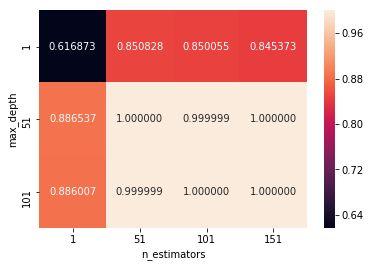

In [101]:
import seaborn as sns

dat1 = pd.DataFrame(x, columns=['max_depth'])
dat1['n_estimators'] = y
dat1['auc_score'] = z_train
da1 = dat1.pivot('max_depth','n_estimators','auc_score')
ax1 = sns.heatmap(da1, annot=True, fmt="f")

## Cross validation auc report

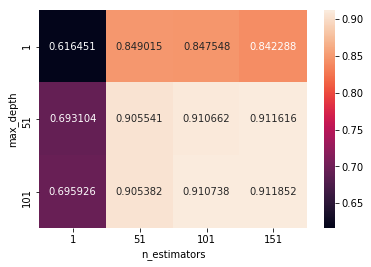

In [102]:
dat2 = pd.DataFrame(x, columns=['max_depth'])
dat2['n_estimators'] = y
dat2['auc_score'] = z_test
da2 = dat2.pivot('max_depth','n_estimators','auc_score')
ax2 = sns.heatmap(da2, annot=True, fmt="f")

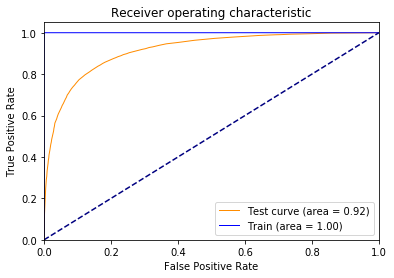

Accuracy on test set: 0.84%
Precision on test set: 0.84%
Recall on test set: 0.84%
F1 score on test set: 0.84%


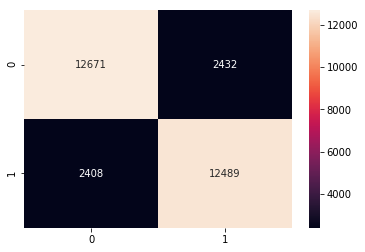

In [103]:
#training the model with best value of hyper parameter
clf = RandomForestClassifier(max_depth=max_depth_opt, n_estimators=n_estimator_opt)
clf.fit(X_tra,Y_train)
y_pred = clf.predict_proba(X_tes)
y_pred_tr = clf.predict_proba(X_tra)
y_pr = clf.predict(X_tes)

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Y_test, y_pred[:,1], pos_label='positive')
fpr_tr, tpr_tr, thresholds_tr = roc_curve(Y_train, y_pred_tr[:,1], pos_label='positive')

roc_auc_te = auc(fpr, tpr)
roc_auc_tr = auc(fpr_tr, tpr_tr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='Test curve (area = %0.2f)' % roc_auc_te)
plt.plot(fpr_tr, tpr_tr, color='blue', lw=1, label='Train (area = %0.2f)' % roc_auc_tr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

print('Accuracy on test set: %0.2f%%'%(accuracy_score(Y_test, y_pr)))
print('Precision on test set: %0.2f%%'%(precision_score(Y_test, y_pr, pos_label='positive')))
print('Recall on test set: %0.2f%%'%(recall_score(Y_test, y_pr, pos_label='positive')))
print('F1 score on test set: %0.2f%%'%(f1_score(Y_test, y_pr, pos_label='positive')))
ax = sns.heatmap(confusion_matrix(Y_test, y_pr), annot=True, fmt='d')

## [3.3.1.2] Gradient Boosting Decision Trees

In [104]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, make_scorer

def custom_auc(ground_truth, predictions):
    fpr, tpr, _ = roc_curve(ground_truth, predictions[:, 1], pos_label='positive')    
    return auc(fpr, tpr)

auc_ = make_scorer(custom_auc, greater_is_better=True, needs_proba=True)

base_models = [i for i in range(1,200,50)]
depth = [i for i in range(1,10,2)]
clf = XGBClassifier(booster='gbtree')
param_grid = {'max_depth':depth,'n_estimators':base_models}
gsv = GridSearchCV(estimator = clf, param_grid=param_grid, verbose=1, scoring=auc_)
gsv.fit(X_tra, Y_train)
print("best depth = ", gsv.best_params_)
print("Best AUC score = ", gsv.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 43.7min finished


best depth =  {'max_depth': 9, 'n_estimators': 151}
Best AUC score =  0.927297131054


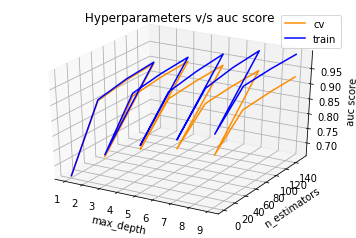

In [105]:
a = gsv.best_params_
max_depth_opt = a['max_depth']
n_estimator_opt = a['n_estimators']

x = []
y = []
z = []
import math
from mpl_toolkits.mplot3d import Axes3D 

for i in gsv.grid_scores_:
    #print(i)
    x.append(i[0]['max_depth'])
    y.append(i[0]['n_estimators'])
        
    
z_test = gsv.cv_results_['mean_test_score']    
z_train = gsv.cv_results_['mean_train_score']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')    
ax.set_xlabel('max_depth')
ax.set_ylabel('n_estimators')
ax.set_zlabel('auc score')
ax.plot(x,y,z_test, color = 'darkorange', label='cv')
ax.plot(x,y,z_train, color = 'blue', label='train')
ax.legend()
plt.title(' Hyperparameters v/s auc score')
plt.show()

## Training auc report

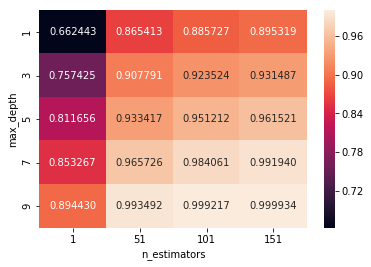

In [106]:
import seaborn as sns

dat1 = pd.DataFrame(x, columns=['max_depth'])
dat1['n_estimators'] = y
dat1['auc_score'] = z_train
da1 = dat1.pivot('max_depth','n_estimators','auc_score')
ax1 = sns.heatmap(da1, annot=True, fmt="f")

## Cross validation auc report

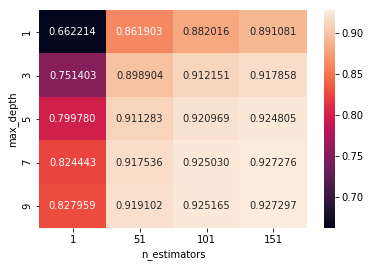

In [107]:
dat2 = pd.DataFrame(x, columns=['max_depth'])
dat2['n_estimators'] = y
dat2['auc_score'] = z_test
da2 = dat2.pivot('max_depth','n_estimators','auc_score')
ax2 = sns.heatmap(da2, annot=True, fmt="f")

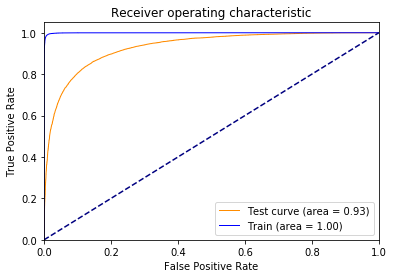

Accuracy on test set: 0.86%
Precision on test set: 0.86%
Recall on test set: 0.85%
F1 score on test set: 0.85%


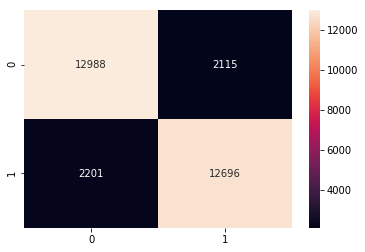

In [108]:
#training the model with best value of hyper parameter
clf = XGBClassifier(max_depth=max_depth_opt, n_estimators=n_estimator_opt, booster='gbtree')
clf.fit(X_tra,Y_train)
y_pred = clf.predict_proba(X_tes)
y_pred_tr = clf.predict_proba(X_tra)
y_pr = clf.predict(X_tes)

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Y_test, y_pred[:,1], pos_label='positive')
fpr_tr, tpr_tr, thresholds_tr = roc_curve(Y_train, y_pred_tr[:,1], pos_label='positive')

roc_auc_te = auc(fpr, tpr)
roc_auc_tr = auc(fpr_tr, tpr_tr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='Test curve (area = %0.2f)' % roc_auc_te)
plt.plot(fpr_tr, tpr_tr, color='blue', lw=1, label='Train (area = %0.2f)' % roc_auc_tr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

print('Accuracy on test set: %0.2f%%'%(accuracy_score(Y_test, y_pr)))
print('Precision on test set: %0.2f%%'%(precision_score(Y_test, y_pr, pos_label='positive')))
print('Recall on test set: %0.2f%%'%(recall_score(Y_test, y_pr, pos_label='positive')))
print('F1 score on test set: %0.2f%%'%(f1_score(Y_test, y_pr, pos_label='positive')))
ax = sns.heatmap(confusion_matrix(Y_test, y_pr), annot=True, fmt='d')

# [3.3.2] TF-IDF weighted W2V

In [109]:
tfidf_vect = TfidfVectorizer()
final_tfidf = tfidf_vect.fit_transform(X_train)

tfidf_feat = tfidf_vect.get_feature_names()

tfidf_sent_vectors_tr = []
row=0
for sent in list_of_sent: 
    sent_vec = np.zeros(100) 
    weight_sum =0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = final_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_tr.append(sent_vec)
    row += 1

In [110]:
tfidf_sent_vectors_TEST = []
row=0
for sent in list_of_sent_test:  
    sent_vec = np.zeros(100) 
    weight_sum =0
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = final_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_TEST.append(sent_vec)
    row += 1    

In [111]:
#standardization
from sklearn.preprocessing import StandardScaler
std = StandardScaler(copy=True, with_mean=False, with_std=True)

X_tra = std.fit_transform(sent_vectors_TRAIN)
X_tes = std.transform(sent_vectors_TEST)

print(X_tra.shape)
print(X_tes.shape)

(70000, 100)
(30000, 100)


## [3.3.2.1] Random Forest

In [112]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, make_scorer

def custom_auc(ground_truth, predictions):
    fpr, tpr, _ = roc_curve(ground_truth, predictions[:, 1], pos_label='positive')    
    return auc(fpr, tpr)

auc_ = make_scorer(custom_auc, greater_is_better=True, needs_proba=True)

base_models = [i for i in range(1,200,50)]
depth = [i for i in range(1,151,50)]

clf = RandomForestClassifier()
param_grid = {'max_depth':depth,'n_estimators':base_models}
gsv = GridSearchCV(estimator = clf, param_grid=param_grid, verbose=1, scoring=auc_)
gsv.fit(X_tra, Y_train)
print("best depth = ", gsv.best_params_)
print("Best AUC score = ", gsv.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 36.0min finished


best depth =  {'max_depth': 51, 'n_estimators': 151}
Best AUC score =  0.912284272125


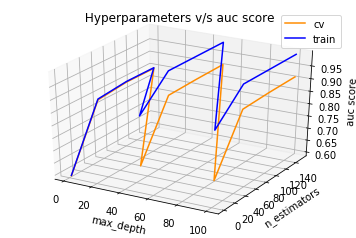

In [113]:
a = gsv.best_params_
max_depth_opt = a['max_depth']
n_estimator_opt = a['n_estimators']

x = []
y = []
z = []
import math
from mpl_toolkits.mplot3d import Axes3D 

for i in gsv.grid_scores_:
    #print(i)
    x.append(i[0]['max_depth'])
    y.append(i[0]['n_estimators'])
        
    
z_test = gsv.cv_results_['mean_test_score']    
z_train = gsv.cv_results_['mean_train_score']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')    
ax.set_xlabel('max_depth')
ax.set_ylabel('n_estimators')
ax.set_zlabel('auc score')
ax.plot(x,y,z_test, color = 'darkorange', label='cv')
ax.plot(x,y,z_train, color = 'blue', label='train')
ax.legend()
plt.title(' Hyperparameters v/s auc score')
plt.show()

## Training auc report

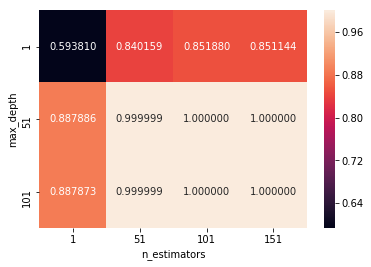

In [114]:
import seaborn as sns

dat1 = pd.DataFrame(x, columns=['max_depth'])
dat1['n_estimators'] = y
dat1['auc_score'] = z_train
da1 = dat1.pivot('max_depth','n_estimators','auc_score')
ax1 = sns.heatmap(da1, annot=True, fmt="f")

## Cross Validation auc report

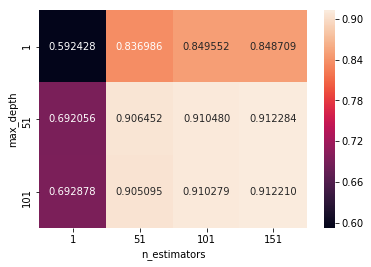

In [115]:
dat2 = pd.DataFrame(x, columns=['max_depth'])
dat2['n_estimators'] = y
dat2['auc_score'] = z_test
da2 = dat2.pivot('max_depth','n_estimators','auc_score')
ax2 = sns.heatmap(da2, annot=True, fmt="f")

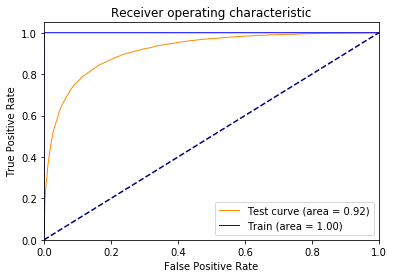

Accuracy on test set: 0.84%
Precision on test set: 0.84%
Recall on test set: 0.84%
F1 score on test set: 0.84%


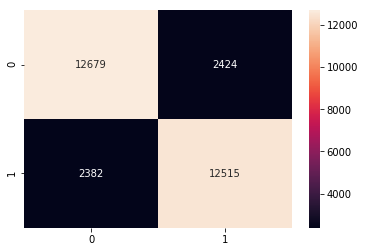

In [116]:
#training the model with best value of hyper parameter
clf = RandomForestClassifier(max_depth=max_depth_opt, n_estimators=n_estimator_opt)
clf.fit(X_tra,Y_train)
y_pred = clf.predict_proba(X_tes)
y_pred_tr = clf.predict_proba(X_tra)
y_pr = clf.predict(X_tes)

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Y_test, y_pred[:,1], pos_label='positive')
fpr_tr, tpr_tr, thresholds_tr = roc_curve(Y_train, y_pred_tr[:,1], pos_label='positive')

roc_auc_te = auc(fpr, tpr)
roc_auc_tr = auc(fpr_tr, tpr_tr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='Test curve (area = %0.2f)' % roc_auc_te)
plt.plot(fpr_tr, tpr_tr, color='blue', lw=1, label='Train (area = %0.2f)' % roc_auc_tr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

print('Accuracy on test set: %0.2f%%'%(accuracy_score(Y_test, y_pr)))
print('Precision on test set: %0.2f%%'%(precision_score(Y_test, y_pr, pos_label='positive')))
print('Recall on test set: %0.2f%%'%(recall_score(Y_test, y_pr, pos_label='positive')))
print('F1 score on test set: %0.2f%%'%(f1_score(Y_test, y_pr, pos_label='positive')))
ax = sns.heatmap(confusion_matrix(Y_test, y_pr), annot=True, fmt='d')

## [3.3.2.2] Gradient Boosting Decision Trees

In [43]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, make_scorer

def custom_auc(ground_truth, predictions):
    fpr, tpr, _ = roc_curve(ground_truth, predictions[:, 1], pos_label='positive')    
    return auc(fpr, tpr)

auc_ = make_scorer(custom_auc, greater_is_better=True, needs_proba=True)

base_models = [i for i in range(1,200,50)]
depth = [i for i in range(1,10,2)]
clf = XGBClassifier(booster='gbtree')
param_grid = {'max_depth':depth,'n_estimators':base_models}
gsv = GridSearchCV(estimator = clf, param_grid=param_grid, verbose=1, scoring=auc_)
gsv.fit(X_tra, Y_train)
print("best depth = ", gsv.best_params_)
print("Best AUC score = ", gsv.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 76.3min finished


best depth =  {'max_depth': 9, 'n_estimators': 151}
Best AUC score =  0.927397970917


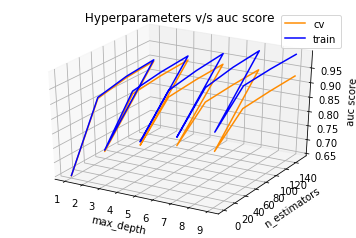

In [56]:
a = gsv.best_params_
max_depth_opt = a['max_depth']
n_estimator_opt = a['n_estimators']

x = []
y = []
z = []
import math
from mpl_toolkits.mplot3d import Axes3D 

for i in gsv.grid_scores_:
    #print(i)
    x.append(i[0]['max_depth'])
    y.append(i[0]['n_estimators'])
        
    
z_test = gsv.cv_results_['mean_test_score']    
z_train = gsv.cv_results_['mean_train_score']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')    
ax.set_xlabel('max_depth')
ax.set_ylabel('n_estimators')
ax.set_zlabel('auc score')
ax.plot(x,y,z_test, color = 'darkorange', label='cv')
ax.plot(x,y,z_train, color = 'blue', label='train')
ax.legend()
plt.title(' Hyperparameters v/s auc score')
plt.show()

## Training auc report

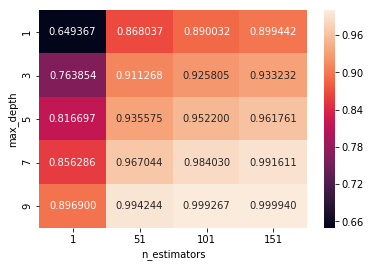

In [60]:
import seaborn as sns

dat1 = pd.DataFrame(x, columns=['max_depth'])
dat1['n_estimators'] = y
dat1['auc_score'] = z_train
da1 = dat1.pivot('max_depth','n_estimators','auc_score')
ax1 = sns.heatmap(da1, annot=True, fmt="f")

## Cross validation auc report

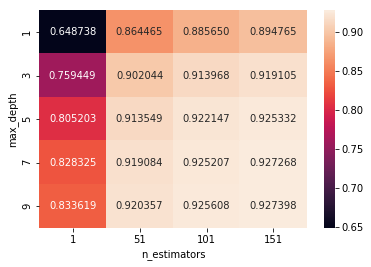

In [58]:
dat2 = pd.DataFrame(x, columns=['max_depth'])
dat2['n_estimators'] = y
dat2['auc_score'] = z_test
da2 = dat2.pivot('max_depth','n_estimators','auc_score')
ax2 = sns.heatmap(da2, annot=True, fmt="f")

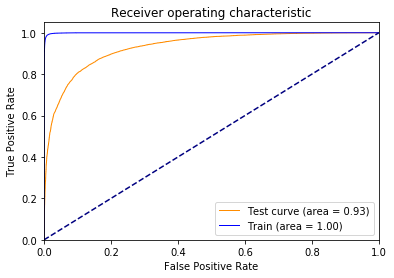

Accuracy on test set: 0.85%
Precision on test set: 0.85%
Recall on test set: 0.85%
F1 score on test set: 0.85%


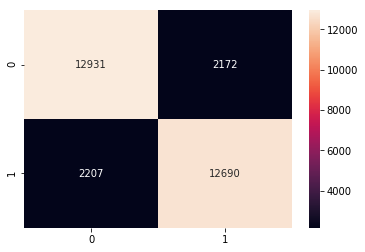

In [45]:
#training the model with best value of hyper parameter
clf = XGBClassifier(max_depth=max_depth_opt, n_estimators=n_estimator_opt, booster='gbtree')
clf.fit(X_tra,Y_train)
y_pred = clf.predict_proba(X_tes)
y_pred_tr = clf.predict_proba(X_tra)
y_pr = clf.predict(X_tes)

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Y_test, y_pred[:,1], pos_label='positive')
fpr_tr, tpr_tr, thresholds_tr = roc_curve(Y_train, y_pred_tr[:,1], pos_label='positive')

roc_auc_te = auc(fpr, tpr)
roc_auc_tr = auc(fpr_tr, tpr_tr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='Test curve (area = %0.2f)' % roc_auc_te)
plt.plot(fpr_tr, tpr_tr, color='blue', lw=1, label='Train (area = %0.2f)' % roc_auc_tr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

print('Accuracy on test set: %0.2f%%'%(accuracy_score(Y_test, y_pr)))
print('Precision on test set: %0.2f%%'%(precision_score(Y_test, y_pr, pos_label='positive')))
print('Recall on test set: %0.2f%%'%(recall_score(Y_test, y_pr, pos_label='positive')))
print('F1 score on test set: %0.2f%%'%(f1_score(Y_test, y_pr, pos_label='positive')))
ax = sns.heatmap(confusion_matrix(Y_test, y_pr), annot=True, fmt='d')

# Conclusion

In [1]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["Vectorizer", "Ensemble method", "min_depth", "n_estimators", "AUC Score"]

x.add_row(["BoW", "Random Forest", 101, 151, 0.94])
x.add_row(["BoW", "G.B.D.T", 9, 151, 0.93])
x.add_row(["Tf-idf", "Random Forest", 101, 151, 0.94])
x.add_row(["Tf-idf", "G.B.D.T", 9, 151, 0.93])
x.add_row(["Avg W2V", "Random Forest", 101, 151, 0.92])
x.add_row(["Avg W2V", "G.B.D.T", 9, 151, 0.93])
x.add_row(["Tf-idf W2V", "Random Forest", 51, 151, 0.92])
x.add_row(["Tf-idf W2V", "G.B.D.T", 9, 151, 0.93])

print(x)

+------------+-----------------+-----------+--------------+-----------+
| Vectorizer | Ensemble method | min_depth | n_estimators | AUC Score |
+------------+-----------------+-----------+--------------+-----------+
|    BoW     |  Random Forest  |    101    |     151      |    0.94   |
|    BoW     |     G.B.D.T     |     9     |     151      |    0.93   |
|   Tf-idf   |  Random Forest  |    101    |     151      |    0.94   |
|   Tf-idf   |     G.B.D.T     |     9     |     151      |    0.93   |
|  Avg W2V   |  Random Forest  |    101    |     151      |    0.92   |
|  Avg W2V   |     G.B.D.T     |     9     |     151      |    0.93   |
| Tf-idf W2V |  Random Forest  |     51    |     151      |    0.92   |
| Tf-idf W2V |     G.B.D.T     |     9     |     151      |    0.93   |
+------------+-----------------+-----------+--------------+-----------+
